# Figure 6

In [1]:
from sympy import symbols, exp, solve, logcombine, simplify, Piecewise, lambdify, N, init_printing, Eq
import numpy
import scipy.stats as ss
from sympy.physics.units import seconds, siemens, volts, farads, amperes, milli, micro, nano, pico, ms, s, kg, meters
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
plt.style.use('neuron_color')
import os
import sys
sys.path.append('../')
from Linearity import Neuron
import lmfit
from pickle import dump

In [2]:
def simpleaxis(axes, every=False, outward=False, hideTitle=True):
    if not isinstance(axes, (list, numpy.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        if hideTitle:
            ax.set_title('')

In [3]:
from IPython.display import display, Markdown, Image

In [4]:
init_printing()

## 6 A Circuit diagram

<img src="Fig_6_a.png" alt="Drawing" style="width: 800px;"/>

In [5]:
prefix = '/home/bhalla/Documents/Codes/data'

## 6 B: Fitting voltage clamp data to get parameters

In [7]:
analysisFile = prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/170530/c1_EI/plots/c1_EI.pkl'
plotDir = os.path.dirname(analysisFile)
neuron = Neuron.load(analysisFile)

$g(t) = \bar{g}\frac{( e^\frac{\delta_{onset} - t }{\tau_{decay}} - e^\frac{\delta_{onset} - t }{\tau_{rise}})}{- \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{decay}}{\tau_{decay} - \tau_{rise}}} + \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{rise}}{\tau_{decay} - \tau_{rise}}}}$

In [6]:
def fitFunctionToPSP(time, vector, t_0=0, g_max=0):
    ''' Fits using lmfit '''

    def _doubleExponentialFunction(t, t_0, tOn, tOff, g_max):
        ''' Returns the shape of an EPSP as a double exponential function '''
        tPeak = t_0 + float(((tOff * tOn)/(tOff-tOn)) * numpy.log(tOff/tOn))
        A = 1./(numpy.exp(-(tPeak-t_0)/tOff) - numpy.exp(-(tPeak-t_0)/tOn))
        g = [ g_max * A * (numpy.exp(-(t_point-t_0)/tOff) - numpy.exp(-(t_point-t_0)/tOn)) if  t_point >= t_0 else 0. for t_point in t]
        return numpy.array(g)

    model = lmfit.Model(_doubleExponentialFunction)
    # Fixing values of variables from data
    # Onset time
    if not t_0:
        model.set_param_hint('t_0', value =max(time)/10., min=0., max = max(time))
    else:
        model.set_param_hint('t_0', value = t_0, vary=False)
    # g_max 
    if not g_max:
        model.set_param_hint('g_max', value = max(vector)/10., min = 0., max = max(vector))
    else:
        model.set_param_hint('g_max', value = g_max, vary=False)

    model.set_param_hint('tOn', value =max(time)/5.1 , min = 0., max = max(time))
    model.set_param_hint('t_ratio', value =10., min=1.05)
    model.set_param_hint('tOff', min = 0., expr='tOn*t_ratio')
    model.set_param_hint('t_peak', expr = 't_0 + ((tOff * tOn)/(tOff-tOn)) * log(tOff/tOn)')
    pars = model.make_params()

    result = model.fit(vector, pars, t=time)
    # print (result.fit_report())
    return result

[[Model]]
    Model(_doubleExponentialFunction)
[[Fit Statistics]]
    # function evals   = 99
    # data points      = 2000
    # variables        = 4
    chi-square         = 109634.871
    reduced chi-square = 54.927
    Akaike info crit   = 8016.017
    Bayesian info crit = 8038.420
[[Variables]]
    t_0:       0.00702619 +/- 3.02e-05 (0.43%) (init= 0.009995)
    tOn:       0.00681315 +/- 0.000118 (1.73%) (init= 0.01959804)
    tOff:      0.01720850 +/- 0.000188 (1.09%)  == 'tOn*t_ratio'
    g_max:     184.458128 +/- 0.461645 (0.25%) (init= 20.48352)
    t_ratio:   2.52577659 +/- 0.069629 (2.76%) (init= 10)
    t_peak:    0.01747629 +/- 8.94e-05 (0.51%)  == 't_0 + ((tOff * tOn)/(tOff-tOn)) * log(tOff/tOn)'
[[Correlations]] (unreported correlations are <  0.100)
    C(tOn, t_ratio)              = -0.985 
    C(t_0, tOn)                  = -0.599 
    C(t_0, t_ratio)              =  0.526 
    C(t_0, g_max)                =  0.377 
    C(tOn, g_max)                = -0.287 
    C(g_m

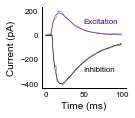

In [9]:
n = {key:value for key,value in neuron}
for numSq in set(n[1]).intersection(set(n[2])):
    for i in set(n[1][numSq].trial).intersection(set(n[2][numSq].trial)):
        if i == 3 and numSq == 7:
            exc = -1e9*n[1][numSq].trial[i].interestWindow
            inh = 1e9*n[2][numSq].trial[i].interestWindow
            time = numpy.arange(len(n[1][numSq].trial[i].interestWindow))*n[1][numSq].trial[i].samplingTime
            exc_fit = fitFunctionToPSP(time, exc)
            inh_fit = fitFunctionToPSP(time, inh)
            print (exc_fit.fit_report())
            print (inh_fit.fit_report())
            fig,ax = plt.subplots() 
            ax.plot(time*1e3, exc, alpha=0.6, c='indigo')
            ax.set_xlabel("Time (ms)")
            ax.set_ylabel("Current (pA)")
            ax.plot(time*1e3, exc_fit.best_fit, label="Excitation", c='indigo')

            ax.plot(time*1e3, -inh, alpha=0.6, c='k')
            ax.plot(time*1e3, -inh_fit.best_fit, label="Inhibition", c='k')
            ax.annotate('Excitation', (50,100), (50,100), xycoords='data',color='indigo')
            ax.annotate('Inhibition', (50,-300), (50,-300), xycoords='data',color='k')
            fig.set_figwidth(1.5)
            fig.set_figheight(1.5)
            simpleaxis(ax)
            dump(fig,file('figures/fig6/6b.pkl','wb'))
            plt.show()

In [17]:
samplingRate = 20  # kHz, to get milliseconds
sample_every = 10 # points
timeStep, maxTime = (sample_every*1.)/ samplingRate, 100.  # ms
trange = numpy.arange(
    0., maxTime, timeStep)  # We will always use 100. ms timecourse of PSPs.

In [48]:
#### Range of $g_e$ explored
emin = 0.01
emax = 3.
e_step = 0.5
erange = numpy.arange(emin, emax, e_step)
#### Range of proportionality ($P$) between $E$ and $I$
prop_array = numpy.arange(0, 6, 1)

In [8]:
## Setting up the variables, parameters and units for simulation
t, P, e_r, e_d, delta_e, rho_e, g_e, i_r, i_d, delta_i, rho_i, g_i, b, Cm, g_L = symbols(
    't P \\tau_{er} \\tau_{ed} \\delta_e \\rho_e \\bar{g}_e \\tau_{ir} \\tau_{id} \\delta_i \\rho_i \\bar{g}_i \\beta C_m \\bar{g}_L',
    positive=True,
    real=True)
leak_rev, e_rev, i_rev, Vm = symbols(
    'Leak_{rev} Exc_{rev} Inh_{rev} V_m', real=True)
SymbolDict = {
    t: "Time (ms)",
    P: "Proportion of $g_i/g_e$",
    e_r: "Excitatory Rise (ms)",
    e_d: "Excitatory Fall (ms)",
    delta_e: "Excitatory onset time (ms)",
    rho_e: "Excitatory $tau$ ratio (fall/rise)",
    g_e: "Excitatory max conductance",
    i_r: "Inhibitory Rise (ms)",
    i_d: "Inhibitory Fall(ms)",
    delta_i: "Inhibitory onset time(ms)",
    rho_i: "Inhibitory $tau$ ratio (fall/rise)",
    g_i: "Inhibitory max conductance",
    b: "Inhibitory/Excitatory $tau$ rise ratio"
}
unitsDict = {
    's': seconds,
    'exp': exp,
    'S': siemens,
    'V': volts,
    'A': amperes,
    'm': meters,
    'kg': kg
}  # This is for lamdify
nS, pF, mV, pA = nano * siemens, pico * farads, milli * volts, pico*amperes
### Estimates from data and averaging them to get a number
estimateDict = {
    P: (1,5),
    #e_r: (1.5 * ms, 5 * ms),
    #e_d: (8. * ms, 20. * ms),
    e_r: (17. * ms, 17. * ms),
    e_d: (18. * ms, 18. * ms),
    delta_e: (0. * ms, 0. * ms),
    rho_e: (2., 7.),
    g_e: (0.02 * nS, 0.25 * nS),
    #i_r: (1.5 * ms, 5. * ms),
    #i_d: (14. * ms, 60. * ms),
    i_r: (12. * ms, 12. * ms),
    i_d: (49. * ms, 49. * ms),
    delta_i: (2. * ms, 4. * ms),
    rho_i: (5., 20.),
    g_i: (0.04 * nS, 0.5 * nS),
    b: (0.5, 5.)
}
averageEstimateDict = {
    key: value[0] + value[1] / 2
    for key, value in estimateDict.items()
}

### Approximating the rest from literature
approximateDict = {
    g_L: 10 * nS,
    e_rev: 0. * mV,
    i_rev: -70. * mV,
    leak_rev: -65. * mV,
    Cm: 100 * pF
}
sourceDict = {
    g_L: "None",
    e_rev: "None",
    i_rev: "None",
    leak_rev: "None",
    Cm: "Neuroelectro.org"
}

| Variable  |  Meaning |  Range |
|---|---|---|
|$t$|Time (ms)|0-100|
|$P$|Proportion of $g_i/g_e$|2-4|
|$\tau_{er}$|Excitatory Rise (ms)|1.5-5|
|$\tau_{ed}$|Excitatory Fall (ms)|8-20|
|$\delta_e$|Excitatory onset time (ms)|0-0|
|$\rho_e$|Excitatory $tau$ ratio (fall/rise)|2-7|
|$\bar{g}_e$|Excitatory max conductance|0.02-0.25|
|$\tau_{ir}$|Inhibitory Rise (ms)|1.5-5|
|$\tau_{id}$|Inhibitory Fall(ms)|14-60|
|$\delta_i$|Inhibitory onset time(ms)|3-15|
|$\rho_i$|Inhibitory $tau$ ratio (fall/rise)|5-20|
|$\bar{g}_i$|Inhibitory max conductance|0.04-0.5|
|$\beta$|Inhibitory/Excitatory $tau$ rise ratio|0.5-5|

| Variable  |  Meaning | Source | Value |
|---|---|---|
|$g_L$|Leak conductance| Fernandos and White, J. Neuro. (2010) | 10 nS |
|$Exc_{rev}$|Excitatory reversal|Calculated (Methods)| 0 mV|
|$Inh_{rev}$|Inhibitory reversal |Calculated (Methods)| -70 mV |
|$Leak_{rev}$|Leak reversal |Fernandos and White, J. Neuro. (2010)| -65 mV |
|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|

---

In [9]:
### Double exponential to explain the net synaptic conductance.
alpha = exp(-(t - delta_e) / e_d) - exp(-(t - delta_e) / e_r)
alpha_prime = alpha.diff(t)
theta_e = solve(alpha_prime, t)  # Time to peak
theta_e = logcombine(theta_e[0])
simplify(theta_e.subs(averageEstimateDict))
alpha_star = simplify(alpha.subs(t, theta_e).doit())

### Finding maximum of the curve and substituting ratio of taus
g_E = Piecewise((0. * nS, t / ms < delta_e / ms), (g_e * (alpha / alpha_star),
                                                   True))
### Final equation for Excitation normalized to be maximum at $g_e$

### Doing the same with inhibition
g_I = g_E.xreplace({
    g_e: g_i,
    rho_e: rho_i,
    e_r: i_r,
    e_d: i_d,
    delta_e: delta_i
})
alpha_I = alpha.xreplace({e_r: i_r, e_d: i_d, delta_e: delta_i})
alpha_star_I = alpha_star.xreplace({e_r: i_r, e_d: i_d})
g_I = Piecewise((0. * nS, t / ms < delta_i / ms),
                (g_i * (alpha_I / alpha_star_I), True))

In [10]:
### Now finding the control peak using difference of these double-exponentials
compartment = Eq((1 / Cm) * (g_E * (Vm - e_rev) + g_I * (Vm - i_rev) + g_L *
                             (Vm - leak_rev)), Vm.diff(t))
Vm_t = solve(compartment, Vm, rational=False, simplify=True)
check_vm_t = Vm_t[0].subs({ i: averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e,g_i, P] }).subs(approximateDict).subs({ g_i: P * g_e })

In [11]:
f = lambdify((g_e, P, t), check_vm_t/mV, (unitsDict, "numpy"))

## 6 C Divisive Inhibition: Inhibition proportional to Excitation, or $g_i = P \times g_e$

In [109]:
di_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
di_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

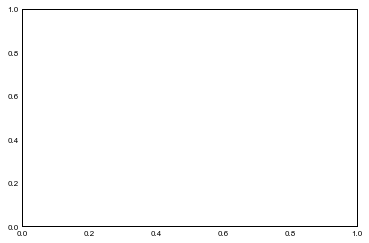

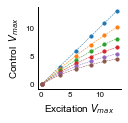

In [110]:
fig, ax = plt.subplots()
# plt.style.context('neuron-color')
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=10))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, di_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6c.pkl','wb'))
# ax.set_title("Divisive Inhibition")
plt.show()

In [ ]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    ttp, e_max = [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        ttp.append(numpy.argmax(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max[1:], ttp[1:], s=10))
    ax.plot(e_max[1:], ttp[1:], '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Time to peak  $t_{peak}$")
ax.set_xlim(0,15)
ax.set_ylim(0,55)
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
# dump(fig,file('figures/fig6/6g.pkl','wb'))
plt.show()

In [ ]:
handles, labels = [], []
for prop in prop_array:
    fig, ax = plt.subplots()
    ttp, e_max = [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        ax.plot(trange, con_trace,c='k')
    fig.set_figwidth(12)
    plt.show()


In [ ]:
threshold = 5.5
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max, spk_t = [], [], []
    for con_trace,e_t in zip(di_control[prop], di_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        spiking = numpy.where((numpy.array(con_trace) - float(approximateDict[leak_rev]/mV)) > threshold)[0]
        if len(spiking):
            spk_t.append(spiking[0])
        else:
            spk_t.append(numpy.nan)
#         print(numpy.where(e_t>threshold))
    handles.append(ax.plot(erange, spk_t, '.-'))
#     ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Spike Time  $t_{sp}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, dn_control[prop][5])
# ax.hlines(y=threshold, linestyle='--')
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
#dump(fig,file('figures/fig6/6e.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

In [ ]:
print ( "Constant $delta_i$ was {:.1f} ms".format(averageEstimateDict[delta_i]/ms))

6 DEF: Divisive Normalization: Inhibition proportional to Excitation, or $g_i = P \times g_e$ and $\delta_i$ inversely proportional to $g_e$

## 6 D Changing $\delta_i$ = $\delta_{min} + me^{-k\times{g_e}}$

In [22]:
time_erange = numpy.linspace(0.01,4.,10)

In [86]:
d = lambda minDelay,k,e: minDelay + m*exp(-(k*e))
nS = nano*siemens
k, m, minDelay = 1.43/nS, 18.15*ms, 2.54*ms
maxDelay = (minDelay + m)/ms

In [103]:
d = lambda minDelay,k,e: minDelay + (k/e)
nS = nano*siemens
k, m, minDelay = 1.5*ms*nS, -1.13, 1.5*ms
maxDelay = (minDelay + m)/ms

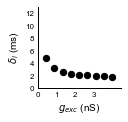

In [104]:
fig, ax = plt.subplots()
ax.scatter(time_erange, [d(minDelay,k,e*nS)/ms for e in time_erange], s=40, facecolor='k', edgecolor='k')
ax.set_xlabel("$g_{exc}$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
ax.set_xlim(0,4.5)
ax.set_ylim(0, 13 )
ax.set_xticks(range(4))
ax.set_yticks(range(0,13,2))
simpleaxis(ax)
dump(fig,file('figures/fig6/6d.pkl','wb'))
plt.show()

In [105]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e, delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, P, t), check_vm/mV, (unitsDict, "numpy"))

In [106]:
dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
dn_control = {prop: [[float(f(e * nS, prop, dt * ms)) for dt in trange] for e in erange] for prop in prop_array}

## 6 E Divisive Normalization 

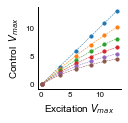

In [107]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=10))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6e.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

### Synapses to threshold

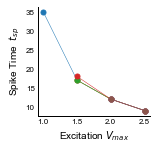

In [43]:
threshold = 5.5
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max, spk_t = [], [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        spiking = numpy.where((numpy.array(con_trace) - float(approximateDict[leak_rev]/mV)) > threshold)[0]
        if len(spiking):
            spk_t.append(spiking[0])
        else:
            spk_t.append(numpy.nan)
#         print(numpy.where(e_t>threshold))
    handles.append(ax.plot(erange, spk_t, '.-'))
#     ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Spike Time  $t_{sp}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, dn_control[prop][5])
# ax.hlines(y=threshold, linestyle='--')
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='right')
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
#dump(fig,file('figures/fig6/6e.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

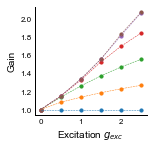

In [44]:
fig, ax = plt.subplots()
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    e_max = numpy.array(e_max)
    v_max = numpy.array(v_max)
    handles.append(ax.scatter(erange, e_max/v_max, s=10))
    ax.plot(erange, e_max/v_max, '--')
ax.set_xlabel("Excitation $g_{exc}$")
ax.set_ylabel("Gain")
fig.set_figwidth(2)
fig.set_figheight(2)
simpleaxis(ax)
plt.show()

## 5 B Model subtraction scheme

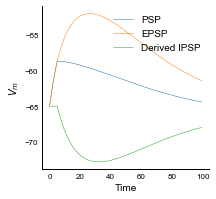

In [45]:
fig, ax = plt.subplots()
handles, labels = [], []
prop = 4

i_max, e_max = [], []
trace_c, trace_e = numpy.array(dn_control[prop][-1]), numpy.array(dn_exc[-1])
ax.plot(trange, trace_c, label="PSP")
ax.plot(trange, trace_e, label="EPSP")
trace_i =  float(approximateDict[leak_rev]/mV) + (trace_c - trace_e)
ax.plot(trange, trace_i, label="Derived IPSP")
ax.set_xlabel("Time")
ax.set_ylabel("$V_m$")
fig.set_figwidth(3)
fig.set_figheight(3)
simpleaxis(ax)
dump(fig,file('figures/fig5/5b.pkl','wb'))
plt.legend()
plt.show()

## 6 F Excitation - Derived Inhibition plot

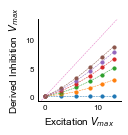

In [46]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    i_max, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        i_t = numpy.array(e_t) - numpy.array(con_trace)
        i_max.append(numpy.max(i_t))
#         i_max.append(max(e_t) - max(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, i_max, s=10))
    ax.plot(e_max, i_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Derived Inhibition  $V_{max}$")
xlim = ax.get_xlim()
ax.set_ylim (xlim)
ax.plot(xlim, xlim, '--')
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6f.pkl','wb'))
plt.show()

## 6 G Time to peak

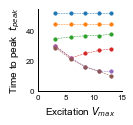

In [47]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    ttp, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        ttp.append(numpy.argmax(con_trace))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max[1:], ttp[1:], s=10))
    ax.plot(e_max[1:], ttp[1:], '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Time to peak  $t_{peak}$")
ax.set_xlim(0,15)
ax.set_ylim(0,55)
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6g.pkl','wb'))
plt.show()

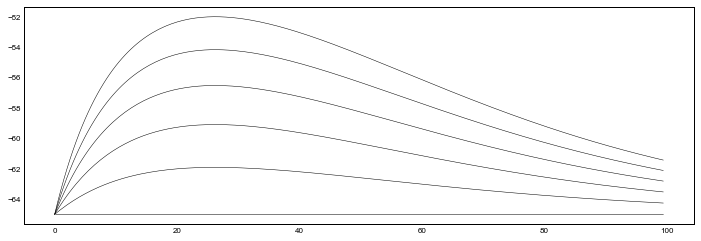

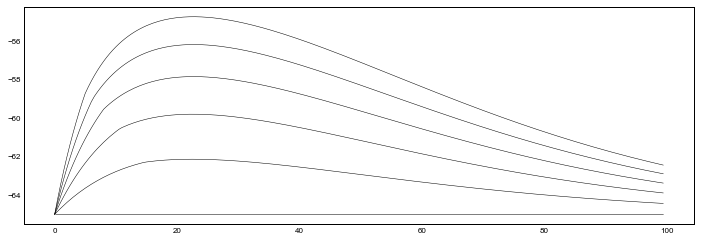

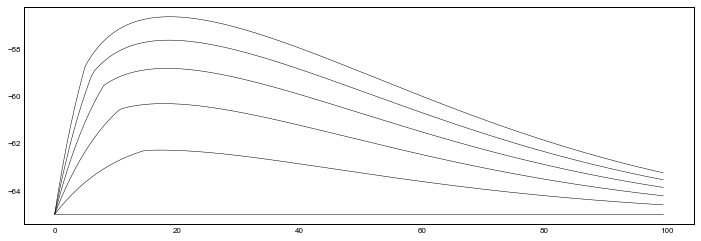

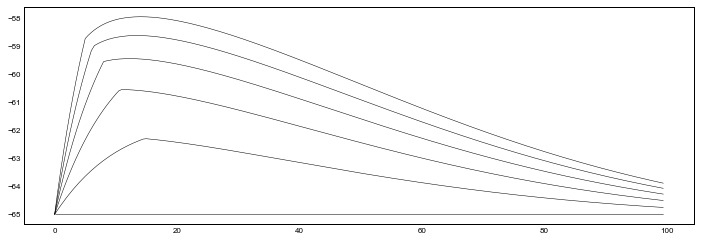

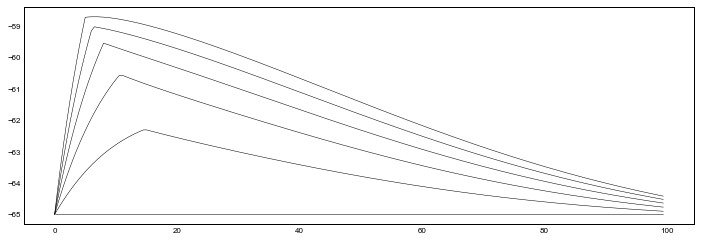

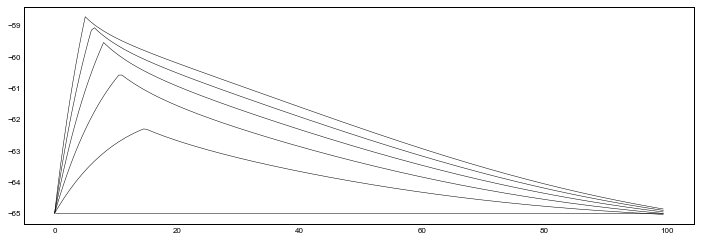

In [57]:
handles, labels = [], []
for prop in prop_array:
    fig, ax = plt.subplots()
    ttp, e_max = [], []
    for con_trace,e_t in zip(dn_control[prop], dn_exc):
        ax.plot(trange, con_trace,c='k')
    fig.set_figwidth(12)
    plt.show()

## 6 H Permutation of P

In [38]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({delta_i: d(minDelay,k,g_e)}).evalf())
f = lambdify((g_e, g_i, t), check_vm/mV, (unitsDict, "numpy"))

In [39]:
p_perm_dn_exc =  [[float(f(e * nS, 0., dt * ms)) for dt in trange] for e in erange]
p_perm_dn_control = {prop: [[float(f(e * nS, i * nS, dt * ms)) for dt in trange] for (e,i) in zip(erange, numpy.random.permutation(erange*prop))] for prop in prop_array}

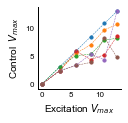

In [40]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(p_perm_dn_control[prop], p_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=10))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, p_perm_dn_control[prop][5])
#ax2.set_xlabel("Time")
#ax2.set_ylabel("Membrane potential (mV)")
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6h.pkl','wb'))
# ax.set_title("Divisive Normalization with E and I balance permuted", fontsize=18)
plt.show()

## 6 I Permutation of $\delta_i$

In [41]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [42]:
d_perm_dn_exc =  [[float(f(e * nS, 0., d(minDelay,k, e* nS), dt * ms)) for dt in trange] for e in erange]
d_perm_dn_control = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, numpy.random.permutation([d(minDelay,k, e* nS) for e in erange])) ] for prop in prop_array}

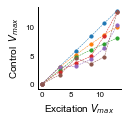

In [43]:
fig, ax = plt.subplots()
handles, labels = [], []
for prop in prop_array:
    v_max, e_max = [], []
    for con_trace,e_t in zip(d_perm_dn_control[prop], d_perm_dn_exc):
        v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
    handles.append(ax.scatter(e_max, v_max, s=10))
    ax.plot(e_max, v_max, '--')
    labels.append("$P= {}$".format(prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
# left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])
# for prop in prop_array:
#     ax2.plot(trange, d_perm_dn_control[prop][5])
# fig.legend(handles, labels, loc ='center right')
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
dump(fig,file('figures/fig6/6i.pkl','wb'))
# ax.set_title("Divisive Normalization", fontsize=18)
plt.show()

## 6 J Phase plot Divisive Normalization

In [44]:
import lmfit
def DN_model(x,a=1):
    # Divisive normalization model
    return (a*x)/(x+a)
DN_Model = lmfit.Model(DN_model)

In [45]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [46]:
inhib = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).evalf())
g = lambdify((g_e, g_i, delta_i, t), inhib/mV, (unitsDict, "numpy"))

In [47]:
phase_dn_control = {}
phase_dn_exc = {}
phase_dn_inh = {}

# prop_array = numpy.logspace(-1,1,7)
# k_array = numpy.logspace(-1,1,7)

prop_array = numpy.linspace(0,6,7)
k_array = numpy.linspace(0.,3.,7)

In [48]:
for k in k_array:
    phase_dn_exc[k] = [[float(f(e * nS, 0., d(minDelay,k/nS, e* nS), dt * ms)) for dt in trange] for e in erange]
    phase_dn_control[k] = {prop: [[float(f(e * nS, prop, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, [d(minDelay,k/nS, e* nS) for e in erange]) ] for prop in prop_array}
#     phase_dn_inh[k] = {prop: [[float(g(0 * nS, prop*e, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, [d(minDelay,k/nS, e* nS) for e in erange]) ] for prop in prop_array}

In [49]:
phase_dn_inh = {}
for k in k_array:
    phase_dn_inh[k] = {prop: [[float(g(0 * nS, prop*e* nS, delay, dt * ms)) for dt in trange] for e,delay in zip(erange, [d(minDelay,k/nS, e* nS) for e in erange]) ] for prop in prop_array}

Max gamma is 3354324684.12


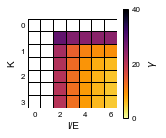

In [269]:
phaseMat_init = numpy.zeros((len(k_array),len(prop_array)))

for ind1, k in enumerate(k_array):
    for ind2, prop in enumerate(prop_array):
        v_max, e_max = [], []
        for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
            v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
            e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        X, y = e_max, v_max
        DN_pars = DN_Model.make_params()
        DN_result = DN_Model.fit(y, DN_pars, x=X)

#         plt.plot(X, y, 'bo')
#         plt.plot(X, DN_result.best_fit, 'r-')
#         plt.xlim(0,1.2*max(e_max))
#         plt.ylim(0,1.2*max(e_max))
#         plt.show()
        phaseMat_init[ind1][ind2] = DN_result.params['a']
#         print(DN_result.fit_report())

# x,y = numpy.meshgrid(prop_array, k_array)

#cmap = LinearSegmentedColormap.from_list('gamma_purple', [(0.,'purple' ), (1., 'white')])
cmap = matplotlib.cm.inferno_r
cmap.set_bad(color='white')

print ("Max gamma is {}".format(numpy.max(phaseMat_init)))
gamma_cutOff = 40
cutOffmask = numpy.ma.masked_where(phaseMat_init > gamma_cutOff, phaseMat_init)
phaseMat = numpy.ma.masked_where(numpy.isnan(phaseMat_init), cutOffmask)

vmax = numpy.nanmax(phaseMat)
vmin = numpy.nanmin(phaseMat)

fig, ax = plt.subplots()

phaseMat 
#heatmap = ax.pcolormesh(phaseMat, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap = cmap, edgecolor='k', linewidths=.05)
heatmap = ax.pcolormesh(phaseMat, vmin=0, vmax=gamma_cutOff, cmap = cmap, edgecolor='k', linewidths=.05)
# ax.grid(True, which='minor', axis='both', linestyle='--', alpha=0.1, color='k')

ax.invert_yaxis()
ticks = numpy.arange(0,len(prop_array),2)
ax.xaxis.set_ticks(ticks+0.5)
ax.yaxis.set_ticks(ticks+0.5)

ax.yaxis.set(ticklabels=["{:.0f}".format(j) for j in k_array[ticks]])
ax.xaxis.set(ticklabels=["{:.0f}".format(j) for j in prop_array[ticks]])


# ax.axis([int(k_array.min()),int(k_array.max()),int(prop_array.min()),int(prop_array.max())])
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_ticks([0,10,10], minor=True)
#     axis.set(ticks=[0,10,10], ticklabels=numpy.linspace(0,10,10)) #Skipping square labels

# ax.set_xlim((-1,1))
# ax.set_ylim((-1,1))

#Colorbar stuff
cbar = plt.colorbar(heatmap, label = "$\\gamma$", ticks=[0,20,40])
cbar.ax.get_yaxis().labelpad = 6
# tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
# cbar.locator = tick_locator
# cbar.update_ticks()

# ax.patch.set(hatch='xx', edgecolor='purple')

simpleaxis(ax,every=True,outward=False)
ax.set_aspect(1)
fig.set_figwidth(2.)
fig.set_figheight(2.)

ax.set_ylabel("K")
ax.set_xlabel("I/E")
# ax.set_title("Divisive Normalization", fontsize=18)

dump(fig,file('figures/supplementary/11a.pkl','wb'))
plt.show()

In [270]:
print (k_array)

[ 0.   0.5  1.   1.5  2.   2.5  3. ]


### Delay plots

In [271]:
d = lambda minDelay,k,e: minDelay + m*exp(-(k*e))
nS = nano*siemens
m, minDelay = 18.15*ms, 2.54*ms
maxDelay = (minDelay + m)/ms

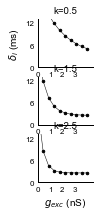

In [272]:
k_sample_indices = [1,3,5]
fig, ax = plt.subplots(len(k_array[k_sample_indices]),1,sharey=True)
for axis,k in zip(ax,k_array[k_sample_indices]):
    axis.plot(time_erange, [d(minDelay,k/nS,e*nS)/ms for e in time_erange], '.-', c='k', markersize=5)
    axis.set_xlim(0,4.5)
    axis.set_ylim(0, 13 )
    axis.set_xticks(range(4))
    axis.set_yticks(range(0,13,6))
    axis.set_title("k={}".format(k))
ax[0].set_ylabel("$\\delta_i$ (ms)")
ax[-1].set_xlabel("$g_{exc}$ (nS)")
simpleaxis(ax,hideTitle=False)
fig.set_figwidth(1)
fig.set_figheight(3)
dump(fig,file('figures/supplementary/11b.pkl','wb'))
plt.show()

### I/E differences

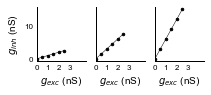

In [273]:
ie_sample_indices = [1,3,6]
fig, ax = plt.subplots(1,3,sharey=True)
for axis,i_by_e in zip(ax, prop_array[ie_sample_indices]):
    axis.plot(erange, i_by_e * erange, '.-', c='k', markersize=5)
    axis.set_xlabel("$g_{exc}$ (nS)")
    axis.set_xlim(0,4.5)
    axis.set_xticks(range(4))
#     axis.set_yticks(range(0,13,2))
#     axis.set_title("I/E={}".format(i_by_e))
ax[0].set_ylabel("$g_{inh}$ (nS)")   
simpleaxis(ax,hideTitle=False)
fig.set_figwidth(3)
fig.set_figheight(1)
dump(fig,file('figures/supplementary/11c.pkl','wb'))
plt.show()

### DN traces for these values

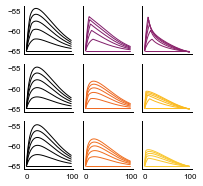

In [286]:
fig, ax = plt.subplots(len(k_sample_indices), len(ie_sample_indices), sharex=True, sharey=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=gamma_cutOff))
for ind1,k_index in enumerate(k_sample_indices):
    for ind2,prop_index in enumerate(ie_sample_indices):
        k, prop = k_array[k_index], prop_array[prop_index]
        for trace in phase_dn_control[k][prop]:
            if phaseMat[k_index][prop_index]:
                ax[ind1][ind2].plot(trange, trace, c=sm.to_rgba(float(phaseMat[k_index][prop_index])), linewidth=1)
            else:
                ax[ind1][ind2].plot(trange, trace, c='k', linewidth=1)
#         ax[ind1][ind2].set_title("K={},I/E={}".format(k,prop))
simpleaxis(fig.get_axes(),hideTitle=False)
fig.set_figwidth(3)
fig.set_figheight(3)
dump(fig,file('figures/supplementary/11d.pkl','wb'))
plt.show()

### SDN curve for these values

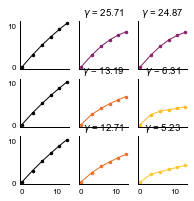

In [275]:
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=gamma_cutOff))
fig, ax = plt.subplots(len(k_sample), len(ie_sample), sharex=True, sharey=True)
for ind1,k_index in enumerate(k_sample_indices):
    for ind2,prop_index in enumerate(ie_sample_indices):
        k, prop = k_array[k_index], prop_array[prop_index]       
        
        obs_sdn = numpy.array([numpy.max(trace) for trace in phase_dn_control[k][prop]]) - float(approximateDict[leak_rev]/mV)
        exp_sdn = numpy.array([numpy.max(trace) for trace in phase_dn_exc[k]])  - float(approximateDict[leak_rev]/mV)
        
        if phaseMat[k_index][prop_index]:
            ax[ind1][ind2].plot(exp_sdn, obs_sdn, '.-', c=sm.to_rgba(float(phaseMat[k_index][prop_index])), markersize=5, linewidth=1)
            ax[ind1][ind2].set_title("$\gamma$ = " + "{:.2f}".format(phaseMat_init[k_index][prop_index]))
#             ax[ind1][ind2].set_title("K={}, I/E={}, ".format(k,prop) + "$\gamma$ = " + "{:.2e}".format(phaseMat_init[k_index][prop_index]))
        else:
            ax[ind1][ind2].plot(exp_sdn, obs_sdn, '.-', c='k', markersize=5, linewidth=1)
            #ax[ind1][ind2].set_title("$\gamma$ > 40")
#             ax[ind1][ind2].set_title("K={}, I/E={}, ".format(k,prop) + "$\gamma$ = " + "{:.2e}".format(phaseMat_init[k_index][prop_index]))


#     if phaseMat[k_index][prop_index]:
#             print (k_index, prop_index)
#             ax[ind1][ind2].set_title("$\gamma$ = " + "{:.2f}".format(phaseMat_init[k_index][prop_index]))
#         else:
#             print ("Didn't work, {},{}".format(k_index, prop_index))
#             ax[ind1][ind2].set_title("$\gamma$ > 40")
simpleaxis(fig.get_axes(),hideTitle=False)
fig.set_figwidth(3)
fig.set_figheight(3)
dump(fig,file('figures/supplementary/11e.pkl','wb'))
plt.show()

In [276]:
exp_sdn, obs_sdn

(array([  1.42108547e-14,   3.09511844e+00,   5.90887286e+00,
          8.47796161e+00,   1.08329669e+01,   1.29995778e+01]),
 array([  1.42108547e-14,   1.88185101e+00,   2.51450521e+00,
          3.07378708e+00,   3.55554570e+00,   3.99203815e+00]))

In [ ]:
k = k_array[4]
p = prop_array[4]

numColors = 10
cm = matplotlib.cm.viridis_r
cgen = (cm(1.*i/numColors) for i in range(numColors))
maxTime = 200

fig, ax = plt.subplots()
for con_trace,exc_trace,inh_trace in zip(phase_dn_control[k][prop][1:], phase_dn_exc[k][1:], phase_dn_inh[k][prop][1:]):
    c = cgen.next()
    ax.plot(con_trace[:maxTime], '-', linewidth=2, c=c)
    ax.plot(exc_trace[:maxTime], '-', linewidth=2, c=c)
    ax.plot( [-65 - (a - b) for a,b in zip(exc_trace[:maxTime],con_trace[:maxTime])], '-', linewidth=2, c=c)
#     ax.plot(inh_trace[:maxTime], '-', linewidth=2, c=c)
    ax.hlines(y=max(con_trace[:maxTime]), xmin=0, xmax=maxTime, linestyles='--')
#     ax.hlines(y=max(con_trace[:maxTime]))
simpleaxis(ax,every=True)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for inh_trace in phase_dn_inh[k][p]:
    ax.plot(inh_trace)
plt.show()

In [ ]:
len(phase_dn_inh[8])

In [ ]:
# for ind1, k in enumerate(k_array):
#     for ind2, prop in enumerate(prop_array):
#         v_max, e_max = [], []
#         for con_trace,e_t in zip(phase_dn_control[k][prop], phase_dn_exc[k]):
#             v_max.append(max(con_trace) - float(approximateDict[leak_rev]/mV))
#             e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
#         X, y = e_max, v_max
#         DN_pars = DN_Model.make_params()
#         DN_result = DN_Model.fit(y, DN_pars, x=X)
#         print (k, prop)
#         print(DN_result.fit_report())
#         f,ax = plt.subplots()
#         DN_result.plot_fit(ax)
#         plt.show()

## 6 K $\delta_i$ as a function of $g_e$

In [192]:
prefix = '/home/bhalla/Documents/Codes/data'
n = Neuron.load(prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/170720/c5_EI/plots/c5_EI.pkl')

In [277]:
def delay_excitation(x, a=1., b=1., c=1.):
    # Delay as a function of excitation
#     return a + b*numpy.exp(-c*x)
    return a+(x**b)

In [256]:
def findOnsetTime(trial, step=0.5, slide = 0.05, minOnset = 2., maxOnset = 50., initpValTolerance=1.0, pValMinTolerance = 0.1):
    maxIndex = int(trial.F_sample*maxOnset*1e-3)
    if expType == 1:
        maxOnsetIndex = numpy.argmax(-trial.interestWindow[:maxIndex])
    elif expType == 2:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    else:
        maxOnsetIndex = numpy.argmax(trial.interestWindow[:maxIndex])
    
    window_size = len(trial.interestWindow)
    step_size = int(trial.F_sample*step*1e-3)
    
    overlap =  int(trial.F_sample*slide*1e-3)
    
    index_right = maxOnsetIndex
    index_left = index_right - step_size
    minOnsetIndex = int(trial.F_sample*minOnset*1e-3)
    
    baseMean = numpy.mean(trial.interestWindow[:minOnsetIndex])
    factor = 5
    thresholdGradient = 0.01
    pValTolerance = initpValTolerance

    l_window = trial.interestWindow[:minOnsetIndex]
    while (index_left>minOnset):
        r_window = trial.interestWindow[index_left:index_right] #, trial.baselineWindow #trial.interestWindow[index_left - step_size:index_left]
        stat, pVal = ss.ks_2samp(r_window, l_window)
        if pVal>pValTolerance:
            return float(index_right)/trial.F_sample

        else:
            index_left-=overlap
            index_right-=overlap
            if index_left<=minOnsetIndex:
                pValTolerance/=2
                if pValTolerance<pValMinTolerance:
#                             print ("Returning Nan")
                            return numpy.nan
                else:
                    index_right = maxOnsetIndex
                    index_left = maxOnsetIndex - step_size

In [211]:
# avg_exc_onset = {}
# avg_inh_onset = {}
# avg_exc_max = {}
# exc_onsets, inh_onsets = {}, {}
# exc_max,inh_max = {}, {}
# err_inh_onsets = {}
# scalingFactor = 1e6
# for expType, experiment in n:
#     for sqr in experiment:
#         for coord in experiment[sqr].coordwise:
#             if expType == 1:
#                 for trial in experiment[sqr].coordwise[coord].trials:
#                     exc_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
#                     exc_max[(sqr,trial.index)] = -trial.feature[5]*scalingFactor
#                     #exp[sqr].coordwise[coord].average_feature[5]
#             if expType == 2:
#                 list_inh_onset = []
#                 for trial in experiment[sqr].coordwise[coord].trials:
#                     inh_onsets[(sqr,trial.index)] = findOnsetTime(trial)*1e3
#                     list_inh_onset.append(inh_onsets[(sqr,trial.index)])
#                     inh_max[(sqr,trial.index)] = trial.feature[0]*scalingFactor
#                 avg_onset = numpy.nanmean([onset for onset in list_inh_onset if onset])
#                 err_onset = numpy.nanstd([onset for onset in list_inh_onset if onset])
#                 for trial in experiment[sqr].coordwise[coord].trials:
#                     avg_inh_onset[(sqr,trial.index)] = avg_onset
#                     err_inh_onsets[(sqr,trial.index)] = err_onset
#print (avg_exc_max, avg_exc_onset, avg_inh_onset)

In [219]:
avg_exc_onset = {}
avg_inh_onset = {}
avg_exc_max = {}
exc_onsets, inh_onsets = {}, {}
exc_max,inh_max = {}, {}
err_exc_onset, err_inh_onset = {}, {}
scalingFactor = 1e6

for expType, experiment in n:
    for sqr in experiment:
        for coord in experiment[sqr].coordwise:
            if expType == 1:
                list_exc_onset = []
                list_exc_max = []
                for trial in experiment[sqr].coordwise[coord].trials:
                    onsetTime = findOnsetTime(trial)
                    if onsetTime:
                        exc_onsets[(sqr,trial.index)] = onsetTime*1e3
                        list_exc_onset.append(exc_onsets[(sqr,trial.index)])
                        list_exc_max.append(-trial.feature[5]*scalingFactor)
                    #exp[sqr].coordwise[coord].average_feature[5]
                avg_exc_onset[coord] = numpy.nanmean([onset for onset in list_exc_onset if onset])
                err_exc_onset[coord] = numpy.nanstd([onset for onset in list_exc_onset if onset])
                exc_max[coord] = numpy.nanmean([maxC for maxC in list_exc_max if maxC])
#                 for trial in experiment[sqr].coordwise[coord].trials:
#                     avg_exc_onset[(sqr,trial.index)] = avg_onset
#                     err_exc_onsets[(sqr,trial.index)] = err_onset
            if expType == 2:
                list_inh_onset = []
                for trial in experiment[sqr].coordwise[coord].trials:
                    onsetTime = findOnsetTime(trial)
                    if onsetTime:
                        inh_onsets[(sqr,trial.index)] = onsetTime*1e3
                        list_inh_onset.append(inh_onsets[(sqr,trial.index)])
                        inh_max[(sqr,trial.index)] = trial.feature[0]*scalingFactor
                avg_inh_onset[coord] = numpy.nanmean([onset for onset in list_inh_onset if onset])
                err_inh_onset[coord] = numpy.nanstd([onset for onset in list_inh_onset if onset])
#                 for trial in experiment[sqr].coordwise[coord].trials:
#                     avg_inh_onset[(sqr,trial.index)] = avg_onset
#                     err_inh_onsets[(sqr,trial.index)] = err_onset

In [220]:
delay, max_current = [], []
del_err, max_err= [], []
inhibOnset = []
conductanceConversion = 70e-3
for key in set(avg_exc_onset).intersection(set(avg_inh_onset)):
    if avg_inh_onset[key] and avg_exc_onset[key]:
        if not numpy.isnan(avg_inh_onset[key]) and not numpy.isnan (avg_exc_onset[key]) and not numpy.isnan (exc_max[key]):
            delay.append(avg_inh_onset[key]- avg_exc_onset[key])
            max_current.append(exc_max[key])
#             del_err.append(err_inh_onset[key])
            inhibOnset.append(avg_inh_onset[key])
maxConductance = numpy.array(max_current)/conductanceConversion
#         del_err.append()
#         max_err.append()

In [234]:
delay_Model = lmfit.Model(delay_excitation)
delay_pars = delay_Model.make_params()

delay = numpy.array(delay)
maxConductance = numpy.array(maxConductance)
# print (delay_result.params)
# print (delay_result.aic)
# print (delay_result.redchi)

In [235]:
delay_result = delay_Model.fit(delay, delay_pars, x=maxConductance)

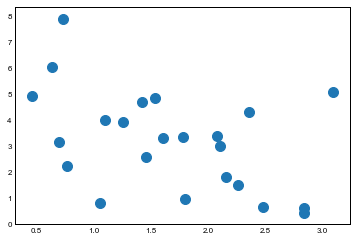

In [236]:
fig, ax = plt.subplots()
ax.scatter(maxConductance, delay)
ax.set_ylim(0,)
plt.show()

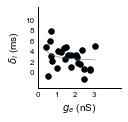

2.06 + E^--0.98
[[Model]]
    Model(delay_excitation)
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 25
    # variables        = 3
    chi-square         = 104.590
    reduced chi-square = 4.754
    Akaike info crit   = 41.779
    Bayesian info crit = 45.436
[[Variables]]
    a:   2.06465796 +/- 0        (0.00%) (init= 1)
    c:   1          +/- 0        (0.00%) (init= 1)
    b:  -0.98294230 +/- 0        (0.00%) (init= 1)



In [237]:
delay_result = delay_Model.fit(delay, delay_pars, x=maxConductance)
fig, ax = plt.subplots()
indices = numpy.argsort(maxConductance)
ax.scatter(maxConductance[indices], delay[indices], s=30, facecolor='k', edgecolor='k')
ax.plot(maxConductance[indices], delay_result.best_fit[indices], '-')
# print(conductance_std, delay_std)
# ax.errorbar(conductance_mean, delay_mean, xerr = conductance_std, yerr= delay_std, linestyle='',c='k')
ax.set_xticks(range(4))
ax.set_yticks(range(0,12,2))
ax.set_xlim(0,4.5)
ax.set_ylim(-3,12.5)
ax.set_xlabel("$g_e$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
# dump(fig,file('figures/fig6/6k.pkl','wb'))
plt.show()
# print ("{:.2f} + {:.2f}e^-{:.2f}E".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))
print ("{:.2f} + E^-{:.2f}".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))
print(delay_result.fit_report())

### Binning delays here

In [155]:
bins = numpy.linspace(0,max(maxConductance),6)
digitized = numpy.digitize(maxConductance, bins)
conductance_mean = [maxConductance[digitized == i].mean() for i in range(len(bins))]
delay_mean = [delay[digitized == i].mean() for i in range(len(bins))]
conductance_std = [maxConductance[digitized == i].std(ddof=1) for i in range(len(bins))]
delay_std = [delay[digitized == i].std(ddof=1) for i in range(len(bins))]

delay_mean, conductance_mean, delay_std, conductance_std = map(list, zip(*[ (d,c,sd,sc) for d,c,sd,sc in zip(delay_mean, conductance_mean, delay_std, conductance_std) if not any(numpy.isnan([d,c,sd,sc]))]))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [156]:
print ("{:.2f} + {:.2f}e^-{:.2f}E".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

-1518.52 + 1520.00e^--0.00E


[0.14239052795104876, 0.17989683703719034, 0.18453625391578368, 0.16077057563100647, 0.063752321261663455] [8.4959024281581197, 1.7754673876037392, 2.1990954015952697, 0.80293005091767888, 0.34883934538536332]


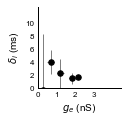

-767.85 + 769.51e^--0.00E


In [157]:
delay_result = delay_Model.fit(delay_mean, delay_pars, x=conductance_mean)
fig, ax = plt.subplots()
ax.scatter(conductance_mean, delay_mean, s=30, facecolor='k', edgecolor='k')
# ax.plot(conductance_mean, delay_result.best_fit, '-')
print(conductance_std, delay_std)
ax.errorbar(conductance_mean, delay_mean, xerr = conductance_std, yerr= delay_std, linestyle='',c='k')
ax.set_xticks(range(4))
ax.set_yticks(range(0,12,2))
ax.set_xlim(0,4.5)
ax.set_ylim(0,12.5)
ax.set_xlabel("$g_e$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
simpleaxis(ax)
# dump(fig,file('figures/fig6/6k.pkl','wb'))
plt.show()
print ("{:.2f} + {:.2f}e^-{:.2f}E".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

In [ ]:
delay_result = delay_Model.fit(delay, delay_pars, x=maxConductance)
fig, ax = plt.subplots()
ax.errorbar(numpy.array(maxConductance), numpy.array(delay), fmt ='o', markersize=2, alpha=0.4)
#ax.scatter(numpy.array(maxConductance)*1e6, numpy.array(delay)*1e3)
current_linspace= numpy.linspace(0,1.1*numpy.max(maxConductance))
ax.plot(current_linspace, delay_result.eval(x=current_linspace), '-', label="${:.2f} + {:.2f} \\times e^{{-{:.2f} \\times E }}$".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

ax.plot(1./(delay_result.params['c'].value), delay_result.eval(x=1./(delay_result.params['c'].value)), 'ko', markersize=2)
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.hlines(y=delay_result.params['a'].value, xmin=xmin, xmax=xmax, linestyles='--', alpha=0.5)
ax.set_xlabel("$g_{max}^{exc}$")
ax.set_ylabel("Delay $(\\delta_{inh})$")

ax.annotate("",
            xy=(xmax, 0.), xycoords='data',
            xytext=(xmax, delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 1., "$\\delta_{min}$")

ax.annotate("",
            xy=(0, 0), xycoords='data',
            xytext=(0, delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(xmin*1.5, 10., "$\\delta_{max}$")

ax.annotate("",
            xy=(xmax, delay_result.params['a'].value), xycoords='data',
            xytext=(xmax,  delay_result.params['b'].value + delay_result.params['a'].value), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
ax.text(1.01*xmax, 10., "$m$")

# ax.text(0.006, 6., "$k$")
ax.set_xlim(xmax= xmax*1.1)
simpleaxis(ax)
plt.legend()
fig.set_figwidth(6)
fig.set_figheight(6)
# dump(fig,file('figures/fig6/6k.pkl','wb'))
plt.show()

### Over all EI cells

In [93]:
voltageClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [94]:
with open (voltageClampFiles,'r') as r:
    dirnames = r.read().splitlines()

IOError: [Errno 2] No such file or directory: '/media/sahil/NCBS_Shares_BGStim/patch_data/voltage_clamp_files.txt'

In [158]:
a = ['161220 c2_EI',
 '170510 c2_EI',
 '170524 c3_EI',
 '170524 c1_EI',
 '170530 c2_EI',
 '170530 c1_EI',
 '170531 c2_EI',
 '170531 c4_EI',
 '170531 c1_EI',
 '170720 c5_EI',
 '170720 c3_EI',
 '170720 c4_EI',
 '170720 c2_EI']
dirnames = (['/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/' + '/'.join(j.split(' ')) + '/' for j in a])

In [159]:
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(numpy.linspace(0,1,len(dirnames)))

In [160]:
neurons = []
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    neurons.append(Neuron.load(filename))

In [257]:
all_delays = []
all_conductances = []
all_inh_conductances = []
scalingFactor = 1e6
for index, n in enumerate(neurons):
    avg_exc_onset = {}
    avg_inh_onset = {}
    avg_exc_max = {}
    exc_onsets, inh_onsets = {}, {}
    exc_max,inh_max = {}, {}
    err_exc_onset, err_inh_onset = {}, {}

    for expType, experiment in n:
        for sqr in experiment:
            for coord in experiment[sqr].coordwise:
                if expType == 1:
                    list_exc_onset = []
                    list_exc_max = []
                    for trial in experiment[sqr].coordwise[coord].trials:
                        onsetTime = findOnsetTime(trial)
                        if onsetTime:
                            exc_onsets[(sqr,trial.index)] = onsetTime*1e3
                            list_exc_onset.append(exc_onsets[(sqr,trial.index)])
                            list_exc_max.append(-trial.feature[5]*scalingFactor)
                        #exp[sqr].coordwise[coord].average_feature[5]
                    avg_exc_onset[coord] = numpy.nanmean([onset for onset in list_exc_onset if onset])
                    err_exc_onset[coord] = numpy.nanstd([onset for onset in list_exc_onset if onset])
                    exc_max[coord] = numpy.nanmean([maxC for maxC in list_exc_max if maxC])
    #                 for trial in experiment[sqr].coordwise[coord].trials:
    #                     avg_exc_onset[(sqr,trial.index)] = avg_onset
    #                     err_exc_onsets[(sqr,trial.index)] = err_onset
                if expType == 2:
                    list_inh_onset = []
                    list_inh_max = []
                    for trial in experiment[sqr].coordwise[coord].trials:
                        onsetTime = findOnsetTime(trial)
                        if onsetTime:
                            inh_onsets[(sqr,trial.index)] = onsetTime*1e3
                            list_inh_onset.append(inh_onsets[(sqr,trial.index)])
                            list_inh_max.append(trial.feature[0]*scalingFactor)
                    avg_inh_onset[coord] = numpy.nanmean([onset for onset in list_inh_onset if onset])
                    err_inh_onset[coord] = numpy.nanstd([onset for onset in list_inh_onset if onset])
                    inh_max[coord] = numpy.nanmean([maxC for maxC in list_inh_max if maxC])

    delay, max_conductance, max_inh_conductance = [], [], []
    inhibOnset = []
    conductanceConversion = 70e-3
    for key in set(avg_exc_onset).intersection(set(avg_inh_onset)):
        if avg_inh_onset[key] and avg_exc_onset[key]:
            if not numpy.isnan(avg_inh_onset[key]) and not numpy.isnan (avg_exc_onset[key]) and not numpy.isnan (exc_max[key]) and not numpy.isnan (inh_max[key]):
                delay.append(avg_inh_onset[key]- avg_exc_onset[key])
                max_conductance.append(exc_max[key]/conductanceConversion)
                max_inh_conductance.append(inh_max[key]/conductanceConversion)
    all_delays.append(delay)
    all_conductances.append(max_conductance)
    all_inh_conductances.append(max_inh_conductance)
    print ("Done {}".format(index))

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Done 8
Done 9
Done 10
Done 11
Done 12


In [ ]:
# all_delays = []
# all_conductances = []
# all_inh_conductances = []
# scalingFactor = 1e6
# for index, n in enumerate(neurons):
#     avg_exc_onset = {}
#     avg_inh_onset = {}
#     avg_exc_max = {}
#     exc_onsets, inh_onsets = {}, {}
#     exc_max,inh_max = {}, {}
#     err_inh_onsets = {}
#     for expType, experiment in n:
#         for sqr in experiment:
#             for coord in experiment[sqr].coordwise:
#                 if expType == 1:
#                     exc_onsets[(sqr,coord)] = []
#                     exc_max[(sqr,coord)] = []
#                     for trial in experiment[sqr].coordwise[coord].trials:
#                         onsetTime = findOnsetTime(trial)
#                         if onsetTime:
#                             exc_onsets[(sqr,coord)].append(onsetTime*1e3)
#                             exc_max[(sqr,coord)].append(-trial.feature[5]*scalingFactor)
#                             #exp[sqr].coordwise[coord].average_feature[5]
#                     exc_onsets[(sqr,coord)] = numpy.nanmean(exc_onsets[(sqr,coord)])
#                     exc_max[(sqr,coord)] = numpy.nanmean(exc_max[(sqr,coord)])
                        
#                 if expType == 2:
#                     inh_onsets[(sqr,coord)] = []
#                     inh_max[(sqr,coord)] = []
#                     #list_inh_onset = []
#                     for trial in experiment[sqr].coordwise[coord].trials:
#                         onsetTime = findOnsetTime(trial)
#                         if onsetTime:
#                             inh_onsets[(sqr,coord)].append(onsetTime*1e3)
#                             #list_inh_onset.append(onsetTime*1e3)
#                             inh_max[(sqr,coord)].append(trial.feature[0]*scalingFactor)
#                     #avg_onset = numpy.nanmean([onset for onset in list_inh_onset if onset])
#                     #err_onset = numpy.nanstd([onset for onset in list_inh_onset if onset])
# #                     for trial in exp[sqr].coordwise[coord].trials:
# #                         avg_inh_onset[(sqr,trial.index)] = avg_onset
# #                         err_inh_onsets[(sqr,trial.index)] = err_onset
#                     inh_onsets[(sqr,coord)] = numpy.nanmean(inh_onsets[(sqr,coord)])
#                     inh_max[(sqr,coord)] = numpy.nanmean(inh_max[(sqr,coord)])
                        
#     delay, max_conductance, max_inh_conductance = [], [], []
# #     del_err, max_err= [], []
#     inhibOnset = []
#     conductanceConversion = 70e-3
#     for key in set(exc_onsets).intersection(set(inh_onsets)):
#         if inh_onsets[key] and exc_onsets[key]:
# #             print ("Doing {}".format(index))
# #             print (inh_onsets[key], exc_onsets[key], exc_max[key])
#             if not numpy.isnan(inh_onsets[key]) and not numpy.isnan (exc_onsets[key]) and not numpy.isnan (exc_max[key]) and not numpy.isnan (inh_max[key]):
# #                 print ("Delay is {}".format(inh_onsets[key]- exc_onsets[key]))
#                 delay.append(inh_onsets[key]- exc_onsets[key])
#                 max_conductance.append(exc_max[key]/conductanceConversion)
#                 max_inh_conductance.append(inh_max[key]/conductanceConversion)
#     all_delays.append(delay)
#     all_conductances.append(max_conductance)
#     all_inh_conductances.append(max_inh_conductance)
#     print ("Done {}".format(index))

In [111]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.viridis

colors = matplotlib.cm.viridis(numpy.linspace(0, 1, len(all_inh_conductances)))

# norm = matplotlib.colors.Normalize(vmin=1, vmax=6)
slopeArr = []
for i, (g, gi, d, c) in enumerate(zip(all_conductances, all_inh_conductances, all_delays, colors)):
    g, gi, d = numpy.array(g), numpy.array(gi), numpy.array(d)
    indices = numpy.argsort(g)
    slope, intercept, rval, pvalue, err = ss.linregress(g[indices], gi[indices])
    #cbar = ax.scatter(g,d, c= [slope]*len(g), s= 10, cmap='viridis', vmin=1.5, vmax=3.2)
    slope, intercept, lowConf, upperConf = ss.mstats.theilslopes(x=gi[indices], y=d[indices])
    #slope, intercept, rval, pvalue, err = ss.linregress(g[indices], d[indices])
    cbar = ax.scatter(gi,d, s=8, c=c, alpha=0.4, cmap='viridis')
    ax.plot(gi, slope*gi + intercept,c=c)
    slopeArr.append(slope)
    
flattened_g = numpy.array([g for sublist in all_conductances for g in sublist])
flattened_d = numpy.array([d for sublist in all_delays for d in sublist])

ax.set_xlabel("$g_e$  (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
# plt.colorbar(cbar)
ax.set_ylim(ymin=-5)
simpleaxis(ax)
fig.set_figwidth(4.5)
fig.set_figheight(4.5)
dump(fig,file('figures/fig6/6l_1.pkl','wb'))
plt.show()

NameError: name 'all_inh_conductances' is not defined

[-3.         -2.72916667 -2.45833333 -2.1875     -1.91666667 -1.64583333
 -1.375      -1.10416667 -0.83333333 -0.5625     -0.29166667 -0.02083333
  0.25      ]


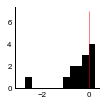

In [182]:
fig, ax = plt.subplots()
bins = numpy.linspace(-3,0.25,13)
print(bins)
ax.hist(slopeArr,bins=bins,color='k')
ax.vlines(x=0,ymin=0,ymax=7.,color='r')
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
plt.show()

### Fitting through all cells

2.26 + -3.27g_e^1.00
[[Model]]
    Model(delay_excitation)
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 21
    # variables        = 3
    chi-square         = 68.279
    reduced chi-square = 3.793
    Akaike info crit   = 30.761
    Bayesian info crit = 33.894
[[Variables]]
    a:   2.26407927 +/- 0        (0.00%) (init= 1)
    c:   1          +/- 0        (0.00%) (init= 1)
    b:  -3.27391330 +/- 0        (0.00%) (init= 1)

0.11 + -0.89g_e^1.00
[[Model]]
    Model(delay_excitation)
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 15
    # variables        = 3
    chi-square         = 77.449
    reduced chi-square = 6.454
    Akaike info crit   = 30.624
    Bayesian info crit = 32.748
[[Variables]]
    a:   0.10783049 +/- 0        (0.00%) (init= 1)
    c:   1          +/- 0        (0.00%) (init= 1)
    b:  -0.89322302 +/- 0        (0.00%) (init= 1)

4.15 + -1.27g_e^1.00
[[Model]]
    Model(delay_excitation)
[[Fit Statistics]]
    # func

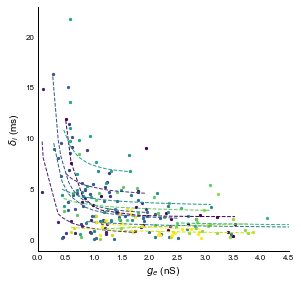

In [287]:
cmap = matplotlib.cm.viridis
colors = matplotlib.cm.viridis(numpy.linspace(0, 1, len(all_inh_conductances)))
fig, ax = plt.subplots()
# norm = matplotlib.colors.Normalize(vmin=1, vmax=6)
slopeArr = []
adist, bdist = [],[]
for i, (g, gi, d, c) in enumerate(zip(all_conductances, all_inh_conductances, all_delays, colors)):
    g, gi, d = numpy.array(g), numpy.array(gi), numpy.array(d)
    indices = numpy.where(d>0)
    g, gi, d = g[indices], gi[indices], d[indices]
    indices = numpy.argsort(g)
    delay_Model = lmfit.Model(delay_excitation)
    delay_pars = delay_Model.make_params()
    
    delay_result = delay_Model.fit(d, delay_pars, x=g)
    indices = numpy.argsort(g)
#     ax.scatter(g[indices], d[indices], s=30, facecolor='k', edgecolor='k')
    ax.scatter(g[indices], d[indices], s=5, facecolor=colors[i], edgecolor=colors[i])
    ax.plot(g[indices], delay_result.best_fit[indices], '--', color=colors[i], linewidth=1)
    print ("{:.2f} + {:.2f}g_e^{:.2f}".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))
    adist.append(delay_result.params['a'].value)
    bdist.append(delay_result.params['b'].value)
    print(delay_result.fit_report())
#     ax.set_xlabel("$g_e$ (nS)")
#     ax.set_ylabel("$\\delta_i$ (ms)")
    # dump(fig,file('figures/fig6/6k.pkl','wb'))
# flattened_g = numpy.array([g for sublist in all_conductances for g in sublist])
# flattened_d = numpy.array([d for sublist in all_delays for d in sublist])
# delay_Model = lmfit.Model(delay_excitation)
# delay_pars = delay_Model.make_params()

# delay_result = delay_Model.fit(flattened_d, delay_pars, x=flattened_g)
# indices = numpy.argsort(flattened_g)
# #     ax.scatter(g[indices], d[indices], s=30, facecolor='k', edgecolor='k')
# ax.plot(flattened_g[indices], delay_result.best_fit[indices], '-',color='k')
# print ("{:.2f} * g_e^{:.2f}".format(delay_result.params['a'].value, delay_result.params['b'].value))#, delay_result.params['c'].value))
# print(delay_result.fit_report())
ax.set_xlabel("$g_e$ (nS)")
ax.set_ylabel("$\\delta_i$ (ms)")
fig.set_figwidth(4.5)
fig.set_figheight(4.5)
ax.set_xlim(0,4.5)
simpleaxis(ax)
plt.show()
# ax.set_xticks(range(4))
# ax.set_yticks(range(0,12,2))

# ax.set_ylim(-3,12.5)

# print ("{:.2f} + {:.2f}e^-{:.2f}E".format(delay_result.params['a'].value, delay_result.params['b'].value, delay_result.params['c'].value))

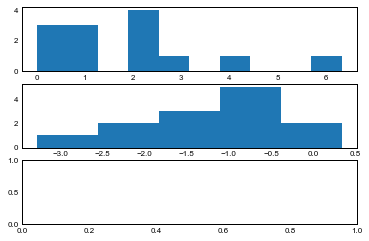

1.94961604632
-1.13308116266


In [292]:
fig, ax = plt.subplots(3,1)
ax[0].hist(adist)
ax[1].hist(bdist,bins=5)
plt.show()
print(numpy.mean(adist))
print(numpy.mean(bdist))

In [183]:
slopeArr

0.0 0.502920157896 4.0 3.53716240317
0.0 4.0
[ 0.72211933  1.76527103  2.50876466] [ 6.40708333  2.96547619  2.41009259] 7.7676647565 -2.30584161713
0.0 0.0722738645753 2.0 1.74271414618
0.0 2.0
[ 0.54185055] [ 0.9352381] nan nan
0.0 0.505398484121 2.0 1.93300685934
0.0 2.0
[ 0.68120182] [ 7.04392857] nan nan
0.0 0.270132300374 2.0 1.95592850845
0.0 2.0
[ 0.68315288] [ 5.25178571] nan nan
0.0 0.120850458198 3.0 2.51118900624
0.0 3.0
[ 0.47828377  1.49302333] [ 1.75923077  1.96464286] 1.66241255834 0.202428383211
0.0 0.873567109263 6.0 5.35349528697
0.0 6.0
[ 0.87356711  1.30101618  2.33452345  3.55241393  4.61094152] [-2.28       -0.50458333 -0.23941667 -0.23833333  1.64833333] -2.32494122391 0.789957466387
0.0 0.434486914483 4.0 3.09986696769
0.0 4.0
[ 0.67206855  1.37256621  2.38862074] [ 4.105       2.21733333  3.82444444] 3.43878956204 -0.0382542599852
0.0 0.467035659221 2.0 1.66198263047
0.0 2.0
[ 0.70340702] [ 7.45833333] nan nan
0.0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


 0.296321428289 13.0 12.6945793162
0.0 13.0
[  0.57949552   2.69445614   3.38869447   4.10863121   5.53230672
   6.14405007   7.65277769   8.34803606   9.32633316  10.41832184
  11.93870242] [-1.46722222 -1.92458333 -3.28333333  1.90666667  0.48541667 -0.56833333
 -0.44180556 -1.03316667  0.93833333  0.71083333 -0.09166667] -1.63782073083 0.188889575416
0.0 0.463261615398 4.0 3.09073761786
0.0 4.0
[ 0.64237947  1.4454997   2.3999953 ] [ 3.93597222  3.17314815  1.62092593] 4.89480013555 -1.32676485611
1.0 1.01333962344 5.0 4.5303571894
1.0 5.0
[ 1.20150093  2.80329751  3.42178479  4.53035719] [ 0.03666667 -0.4953125  -0.00712121 -0.18833333] -0.0258589025231 -0.0460539861728
0.0 0.456571415447 4.0 3.85588180109
0.0 4.0
[ 0.56502321  1.19274374  2.54432978] [ 0.96388889  1.62083333  0.18666667] 1.63967869137 -0.499209413932
1.0 1.02380502318 3.0 2.91772071069
1.0 3.0
[ 1.43717994  2.46114686] [ 0.94783333  0.08872222] 2.15363132281 -0.839002798725


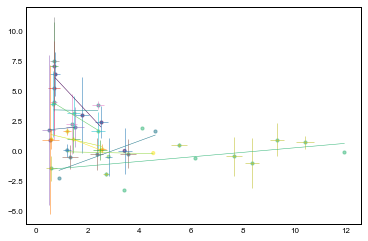

In [171]:
fig, ax = plt.subplots()
cmap = matplotlib.cm.viridis

colors = matplotlib.cm.viridis(numpy.linspace(0, 1, len(all_inh_conductances)))

# norm = matplotlib.colors.Normalize(vmin=1, vmax=6)
for i, (g, gi, d, c) in enumerate(zip(all_conductances, all_inh_conductances, all_delays, colors)):
    g, gi, d = numpy.array(g), numpy.array(gi), numpy.array(d)
    indices = numpy.argsort(g)
    
#     slope, intercept, rval, pvalue, err = ss.linregress(g[indices], gi[indices])
#     print(slope)
    #cbar = ax.scatter(g,d, c= [slope]*len(g), s= 10, cmap='viridis', vmin=1.5, vmax=3.2)
#     print(g)
    gmax = numpy.ceil(max(g))
    gmin = numpy.floor(min(g))
    print(gmin, min(g), gmax, max(g))
#     bins = numpy.linspace(gmin,gmax,(gmax - gmin) +1)
    print (gmin, gmax)
    bins = numpy.arange(gmin,gmax,1)
    indices = numpy.argsort(g)
    
    digitized = numpy.digitize(g[indices], bins)
#     bins = range(8)
    g_means = numpy.array([g[indices][digitized == i].mean() for i in bins])
    g_err = numpy.array([g[indices][digitized == i].std() for i in bins])
    d_means = numpy.array([d[indices][digitized == i].mean() for i in bins])
    d_err = numpy.array([d[indices][digitized == i].std() for i in bins])
    
    finiteYmask = numpy.isfinite(g_means)
    d_means = d_means[finiteYmask]
    g_means = g_means[finiteYmask]
    d_err = d_err[finiteYmask]
    g_err = g_err[finiteYmask]
    
    slope, intercept, rval, pvalue, err = ss.linregress(g_means, d_means)
    
    ax.errorbar(g_means, d_means, xerr = g_err, yerr = d_err, linestyle='')
    cbar = ax.scatter(g_means, d_means, s=10, c=c, alpha=0.5, cmap='viridis')
#     indices = numpy.argsort(g_means)
    print(g_means, d_means, intercept, slope)
    ax.plot(g_means, intercept + slope*g_means, c=c)
plt.show()

In [ ]:
delay_Model = lmfit.Model(delay_excitation)
delay_pars = delay_Model.make_params()

indices = numpy.argsort(flattened_g)
flattened_g = flattened_g[indices]
flattened_d_fit = delay_result.eval(x=flattened_g)

delay_result = delay_Model.fit(flattened_d, delay_pars, x=flattened_g)


fig, ax = plt.subplots()
ax.scatter(flattened_g, flattened_d, s=10, alpha=0.2,c='k')

print(delay_result.fit_report())
ax.plot(flattened_g, flattened_d_fit)
plt.show()
# slope, intercept, rval, pvalue, err = ss.linregress(flattened_g[indices], flattened_d[indices])
# x_axis = numpy.linspace(numpy.min(flattened_g), numpy.max(flattened_g), 100)
# y_axis = slope * x_axis + intercept

# ax.set_xlim(0,6)
# ax.set_ylim(-3,10)

# ax.plot(x_axis, y_axis, '--')
print ( delay_result.params['a'],delay_result.params['b'],delay_result.params['c'])

In [ ]:
keySet = set(inh_onsets).intersection(exc_onsets)

In [ ]:
for key in keySet:
    print (inh_onsets[key], exc_onsets[key])